In [15]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

data=yf.download("NVDA",start="2017-01-01",end="2024-09-01")

# 파일을 잘 가져왔는지 data의 맨 처음 5개 데이터 출력
print(data.head())

[*********************100%***********************]  1 of 1 completed

               Open     High      Low    Close  Adj Close      Volume
Date                                                                 
2017-01-03  2.61000  2.65925  2.48450  2.55025   2.513282  1501996000
2017-01-04  2.58500  2.63750  2.53825  2.60975   2.571920  1199220000
2017-01-05  2.61325  2.64550  2.52625  2.54350   2.506630   984296000
2017-01-06  2.57125  2.60625  2.53000  2.57750   2.540137   822856000
2017-01-09  2.58750  2.70000  2.58750  2.68200   2.643123   916248000


In [50]:
# EMA 계산 (14일 기준)
data['EMA_14'] = ta.trend.ema_indicator(close=data['Close'], window=14)

# RSI 계산 (14일 기준)
data['RSI_14'] = ta.momentum.rsi(close=data['Close'], window=14)

# MACD 계산
macd = ta.trend.MACD(close=data['Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()
data['MACD_diff'] = macd.macd_diff()

# Bollinger Bands 계산 (20일 기준, 2 표준편차)
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()
data['BB_Mid'] = bollinger.bollinger_mavg()

def mean_absolute_deviation(data, window):
    return data.rolling(window=window).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

# 이동 평균과 평균 절대 편차 추가
data['SMA_30'] = ta.trend.sma_indicator(close=data['Close'], window=30)
data['MAD_30'] = mean_absolute_deviation(data['Close'], window=30)


# 결측치 제거 (초기 계산 불가능한 부분)
data.dropna(inplace=True)


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1544e-04 - val_loss: 0.0110
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3011e-04 - val_loss: 0.0106
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6795e-04 - val_loss: 0.0154
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2564e-04 - val_loss: 0.0136
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0046e-04 - val_loss: 0.0101
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6202e-04 - val_loss: 0.0157
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4675e-04 - val_loss: 0.0146
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1253e-04 - val_loss: 0.0112
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1944e-04 - val_loss: 0.0140
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1839e-04 - val_loss: 0.0146
Epoch 12/20
46/46 ━━━━━

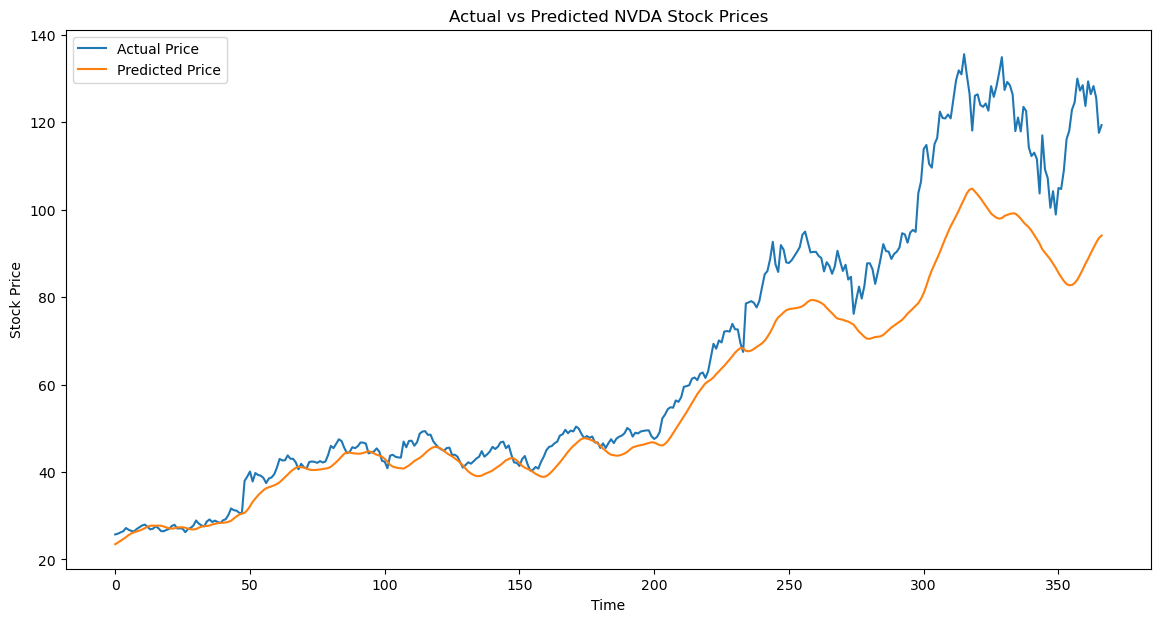

In [51]:
# 예측에 사용할 변수 선택
features = data[['EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_High', 'BB_Low', 'BB_Mid', 'SMA_30', 'MAD_30']]
target = data['Close']

# 데이터 정규화 (Min-Max Scaler)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# 데이터셋을 LSTM 형식으로 변환 (특정 시점 이후의 데이터를 예측하기 위함)
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# 학습 데이터와 테스트 데이터 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 테스트 데이터에 대한 예측
predictions = model.predict(X_test)

# 예측 결과를 원래 스케일로 되돌림
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted NVDA Stock Prices')
plt.legend()
plt.show()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0108 - val_loss: 0.0023
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 7.5580e-04
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 7.2519e-04
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 4.6333e-04
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 5.4970e-04
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6899e-04 - val_loss: 4.1420e-04
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 4.2843e-04
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7866e-04 - val_loss: 4.6442e-04
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6439e-04 - val_loss: 0.0015
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5389e-04 - val_loss: 3.6634e-04
Epoch 12/20
46/46 

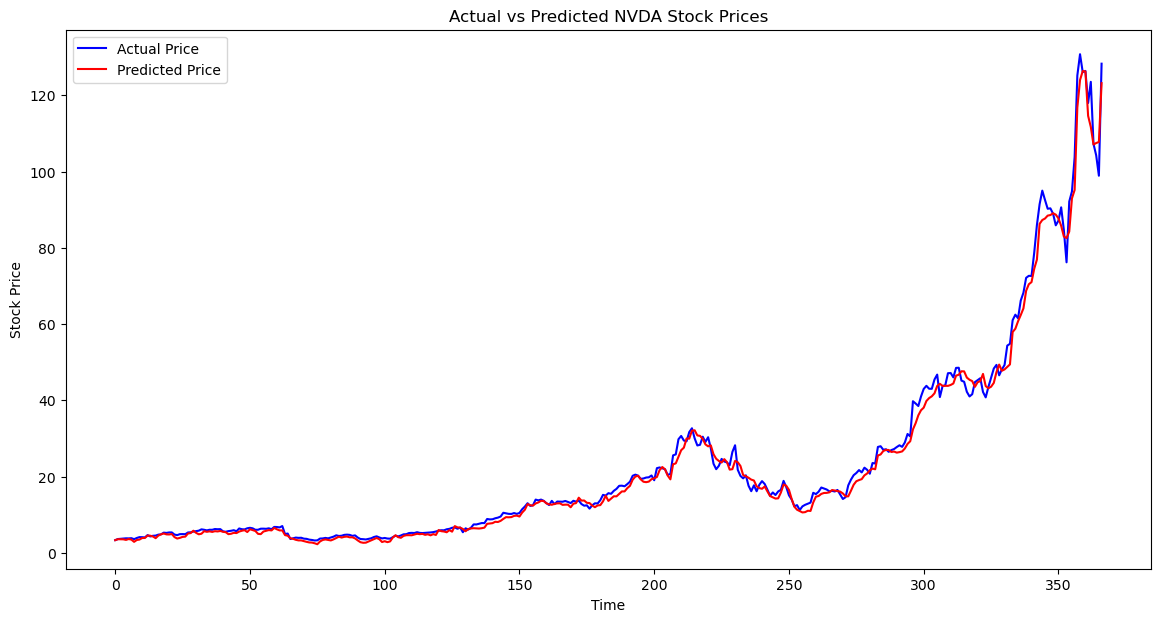

In [53]:
# 예측에 사용할 변수 선택
features = data[['EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_High', 'BB_Low', 'BB_Mid', 'SMA_30', 'MAD_30']]
target = data['Close']

# 데이터 정규화 (Min-Max Scaler)
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# 데이터셋을 LSTM 형식으로 변환 (특정 시점 이후의 데이터를 예측하기 위함)
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X, y = create_sequences(scaled_features, scaled_target, time_steps)

# Cross-validation 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_fold = None
best_model = None
best_rmse = float('inf')
best_predictions = None
best_actuals = None

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # CNN-LSTM 모델 구성
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # 조기 종료 콜백
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 모델 학습
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    
    # 테스트 데이터에 대한 예측
    predictions = model.predict(X_test)
    
    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"RMSE: {rmse*100}%")
    
    # 가장 좋은 fold를 찾기
    if rmse < best_rmse:
        best_rmse = rmse
        best_fold = fold
        best_model = model
        best_predictions = predictions
        best_actuals = y_test

# 예측 결과를 원래 스케일로 되돌림
best_predictions = scaler_target.inverse_transform(best_predictions)
best_actuals = scaler_target.inverse_transform(best_actuals)

# 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(best_actuals, label='Actual Price', color='blue')
plt.plot(best_predictions, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title(f'Actual vs Predicted NVDA Stock Prices')
plt.legend()
plt.show()

In [55]:
# 최고의 모델 저장
best_model.save('..best_cnn_lstm_model.keras')
print(f"Best model saved as 'best_cnn_lstm_model.keras'")

Best model saved as 'best_cnn_lstm_model.keras'
